In [3]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

In [69]:
# считываем лемматизированный датафрэйм

In [5]:
df = pd.read_csv('df3.csv')

In [6]:
df.text[1]

'добрый дня! являться держатель зарплатный карта , выдать сбербанк россии. в 2008 год сменить фамилию, предоставить в банк документ (копия новое паспорта, свидетельство о браке), я перевыпустить карта на фамилия муж токарев мария александр (девичий - секлетина). возникнуть необходимость подключить услуга сбербанк онлайн, не получиться (на главный страница на отображаться мой карты). связаться с технический специалист отделение сбербанк в который обслуживалась. он пояснил, что в база банка, я весь ещё под девичий фамилия секлетина. предложить выслать скан необходимый документов. выслала, оставить контакты, звонок так и не дождалась. ч/з некоторый время звонить сама, объяснять ситуацию, я пробивать по база - опять числиться секлетина (хотеть карта уже перевыпустить ещё раз на фамилия токарев в связь с истечение срок обслуживания). высылать документ (копия паспорт и свидетельство о браке). результат - 0 (ноль). просить помочь разобраться в этот ситуации. с уважение токарев мария александр

In [71]:
# раскладываем на слова

In [7]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

In [70]:
texts[1]

['добрый',
 'дня!',
 'являться',
 'держатель',
 'зарплатный',
 'карта',
 ',',
 'выдать',
 'сбербанк',
 'россии.',
 'в',
 '2008',
 'год',
 'сменить',
 'фамилию,',
 'предоставить',
 'в',
 'банк',
 'документ',
 '(копия',
 'новое',
 'паспорта,',
 'свидетельство',
 'о',
 'браке),',
 'я',
 'перевыпустить',
 'карта',
 'на',
 'фамилия',
 'муж',
 'токарев',
 'мария',
 'александр',
 '(девичий',
 '-',
 'секлетина).',
 'возникнуть',
 'необходимость',
 'подключить',
 'услуга',
 'сбербанк',
 'онлайн,',
 'не',
 'получиться',
 '(на',
 'главный',
 'страница',
 'на',
 'отображаться',
 'мой',
 'карты).',
 'связаться',
 'мария',
 'александр']

In [72]:
# строим модель word2vec

In [8]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("sent_w2v.model")

CPU times: user 8min 48s, sys: 6.48 s, total: 8min 55s
Wall time: 3min 3s


In [73]:
# проверяем как работает

In [9]:
model.most_similar("плохой")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ужасный', 0.7262051105499268),
 ('хороший', 0.7065809965133667),
 ('отвратительный', 0.6994283199310303),
 ('испортиться', 0.6391125917434692),
 ('негативный', 0.6343697309494019),
 ('плохое,', 0.6139699220657349),
 ('идеальный', 0.6015410423278809),
 ('кошмарный', 0.6007797718048096),
 ('портиться', 0.5953694581985474),
 ('медленный', 0.5899024605751038)]

In [10]:
model.most_similar("совка")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('совок,', 0.7808626890182495),
 ('совковый', 0.7098261713981628),
 ('колхоз', 0.6887838840484619),
 ('классно', 0.6752192378044128),
 ('кругом', 0.6737895011901855),
 ('муха', 0.670728862285614),
 ('погода', 0.6676647067070007),
 ('совок.', 0.6671453714370728),
 ('враг', 0.6658894419670105),
 ('маразм', 0.6629449129104614)]

In [11]:
model.most_similar("быстро")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('быстро,', 0.8831470608711243),
 ('быстро.', 0.8314512372016907),
 ('оперативно,', 0.8243264555931091),
 ('оперативно', 0.8050283789634705),
 ('оперативно.', 0.7735873460769653),
 ('быстро:', 0.770875096321106),
 ('грамотно,', 0.7397366166114807),
 ('доброжелательно', 0.7274019718170166),
 ('профессионально', 0.7190403342247009),
 ('быстро!', 0.7182038426399231)]

In [74]:
# перед построением облака слов, убираем все ненужное

In [12]:
# импорт стоп слов 
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [13]:
# добавление дополнительных стоп слов
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'сч', 'ещ']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [14]:
from nltk import FreqDist
top_words = []
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])
print(top_words)

['в', 'я', 'и', 'не', 'на', 'что', 'с', 'быть', 'по', 'это', '-', 'весь', 'банка', 'мой', 'карта', 'а', 'но', 'как', 'о', 'за', 'у', 'банк', 'который', 'к', 'так', 'деньга', 'они', 'вы', 'от', 'она', 'свой', 'для', 'он', 'этот', 'отделение', 'сотрудник', 'мочь', 'же', 'уже', 'через', 'один', 'ещё', 'до', 'такой', 'счёт', 'кредит', 'из', 'день', 'при', 'только', 'сумма', 'мы', 'клиент', 'кредитный', 'дать', 'если', 'заявление', 'раз', 'после', 'получить', 'то', 'ваш', 'время', 'когда', 'тот', 'год', 'бы', 'другой', 'очень', 'чтобы', 'ни', 'номер', 'или', 'звонить', 'два', 'позвонить', 'без', 'вопрос', 'написать', 'офис', 'какой', 'банка,', 'ответ', 'платёж', 'телефон', 'договор', 'банкомат', 'вклад', 'решить', 'должный', 'есть', 'хотеть', 'звонок', 'там', 'вот', 'где', 'можно', 'средство', 'работа', 'просто', 'работать', 'даже', 'обратиться', 'большой', 'почему', 'ли', 'сбербанк', 'месяц', 'срок', 'проблема', '2', 'просить', 'ничто', 'нет', 'сделать', 'никакой', 'информация', 'операция'

In [15]:
top_words_vec = model[top_words]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [76]:
# строим облако

In [75]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

In [77]:
# действительно получились четкие классы:
# слева (-30 ; 14 ) покупка, оплата платеж, снятие списание возврат
# -30 ;4 писать написать оформить заполнить
# еще ниже: забрать выдать, получить, внести


In [78]:
##берем векторы слов хороших и плохих и вычитаем

In [17]:
good=model['хорошо']
bad=model['плохо']
slow=model['медленно']
fast=model['быстро']


x = good - bad
y = fast - slow

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [19]:
model.most_similar("альфа")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('отп', 0.8736619353294373),
 ('райффайзный', 0.7821168899536133),
 ('юникредит', 0.7700337171554565),
 ('сетель', 0.7653316259384155),
 ('связной', 0.7581559419631958),
 ('мдм', 0.7521827816963196),
 ('номос', 0.7519956827163696),
 ('океан', 0.737085223197937),
 ('хкф', 0.7277295589447021),
 ('русфинанс', 0.7087728381156921)]

In [21]:
list1=model.most_similar("сбербанк")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [22]:
list1

[('ситибанк', 0.7994114756584167),
 ('альфа-банк', 0.7692263126373291),
 ('сбербанка,', 0.7369735836982727),
 ('сбер', 0.7229760885238647),
 ('мкб', 0.7064220905303955),
 ('банка', 0.6896098256111145),
 ('росбанк', 0.6837205290794373),
 ('сб', 0.6800389885902405),
 ('сбербанка.', 0.6779881715774536),
 ('промсвязьбанк', 0.6757773160934448)]

In [79]:
# проверяем позитив и негатив

In [23]:
model.most_similar(positive=["хорошо","плохой"], negative=["кредит"])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('плохо', 0.6931405663490295),
 ('здорово', 0.6390696167945862),
 ('печально', 0.633860170841217),
 ('грустно', 0.6297463774681091),
 ('плохо.', 0.6086457967758179),
 ('круто', 0.6032573580741882),
 ('печально.', 0.5903197526931763),
 ('жаль.', 0.5841788053512573),
 ('классно', 0.5813751220703125),
 ('слабо', 0.5786608457565308)]

In [24]:
model.most_similar(positive=["зло","банк"], negative=["хорошо"])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('банк,', 0.5507051348686218),
 ('банк!', 0.5484244227409363),
 ('"банк"', 0.5020362138748169),
 ('банком,', 0.49850139021873474),
 ('банку,', 0.4925374984741211),
 ('банк.', 0.49099043011665344),
 ('банк...', 0.4854814112186432),
 ('мтс-банк', 0.48288553953170776),
 ('отп-банк', 0.47726452350616455),
 ('альфабанк', 0.4752666652202606)]

In [25]:
model.most_similar("сити")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('рс', 0.8113128542900085),
 ('альф', 0.8081720471382141),
 ('авангард', 0.8005663156509399),
 ('райф', 0.7791274189949036),
 ('втб24', 0.7560303211212158),
 ('брс', 0.7543235421180725),
 ('ткс', 0.7418873906135559),
 ('сити,', 0.7105757594108582),
 ('псб', 0.70804762840271),
 ('уралсиб', 0.7032263278961182)]

#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [26]:
responses[99]

NameError: name 'responses' is not defined

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

In [ ]:
v = list(model.wv.vocab.keys())

In [80]:
v

['добрый',
 'день!',
 'я',
 'не',
 'являться',
 'клиент',
 'банка',
 'и',
 'поручитель',
 'по',
 'кредитный',
 'договору,',
 'а',
 'сообщить',
 'ощущение,',
 'вас,',
 ...]

In [27]:
from gensim.models.doc2vec import *

In [28]:
X_train = df.text[:1500].tolist()

In [29]:
X_test = df.text[1501:].tolist()

In [30]:
y = ['быстрый','удобный', 'хороший', 'доступный', 'приятная', 
     'комфортно', 'отлично', 'плохо' ,'супер' 'долго', 'ужасно', 'наглой', 'эмоционально', 'крик', 'хам', 'не очень']

In [45]:
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict

In [31]:
X_test, X_train, y = np.array(X_test), np.array(X_train), np.array(y)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X,X, test_size=0.9)

In [42]:
y.shape

(14,)

In [32]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [33]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [34]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [39]:
X_train[:15]

array(['добрый день! я не являться клиент банка и поручитель по кредитный договору, а также не являться какой-либо другой лицом, письменно оформить отношение с банк по повод урегулирование чей-либо задолженности. начинать с март 2015 год начать приходить бесконечный письмо из ооо "прить коллект"ный мой адрес: город москва, уваровский переулок, дом 10, квартира 111, с угроза о возбуждение уголовный дело в отношение гражданин филиппов эдуард владимировича, который уклоняться от уплата взять имя кредитов: договор № 81014 от 20.10.2013 год и договор № 2464946 от 09.10.2014 года. с весь ответственность хотеть вы заверить, что вышеуказанный гражданин, который вы разыскиваете, я не знак и никогда в мыть адрес не быть зарегистрирован. какой образ вы не удостовериться в подлинность он документ оформить на он имя кредитный договор, я по меньший мера не понятно, и почему по ваш милость я должный переживать и бояться за себя и свой имущество. письмо доставлять я серьёзный неудобства, нарушать мой 

In [40]:
rfc_w2v.fit(X_train[:15],y)
#pred = rfc_w2v.predict(X_test)

Pipeline(memory=None,
     steps=[('word2vec vectorizer', <__main__.MeanEmbeddingVectorizer object at 0x1dd7beac8>), ('extra trees', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impur...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [41]:
pred = rfc_w2v.predict(X_test)

KeyboardInterrupt: 

In [43]:
X = X_train

In [44]:
splitted_texts = [text.split() for text in X]
idx = [str(i) for i in range(len(X))]

docs = []
for i in range(len(X)):
    docs.append(TaggedDocument(splitted_texts[i], [idx[i]]))


model = Doc2Vec(size=300, window=5, min_count=5, workers=8, alpha=0.025, min_alpha=0.01, dm=0)
model.build_vocab(docs)

# docvec1 = model.docvecs[0]
# docvecsyn1 = model.docvecs.doctag_syn0[0]
# docsim1 = model.docvecs.most_similar(id1)

model.train(docs, total_examples=len(docs), epochs=20)

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [48]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model


    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.d2v_model.infer_vector(text.split()) for text in X])


rfc_d2v = Pipeline([
    ("word2vec vectorizer", Doc2VecVectorizer(model)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

rfc_d2v.fit(X_train[:15],y)
pred = rfc_d2v.predict(X_test[100])

In [50]:
from sklearn.metrics import *

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision:   0.00
Recall:   0.07
F1-measure:   0.01
Accuracy:   0.07
              precision    recall  f1-score   support

     быстрый       0.00      0.00      0.00         1
   доступный       0.00      0.00      0.00         1
   комфортно       0.00      0.00      0.00         1
        крик       0.00      0.00      0.00         1
      наглой       0.00      0.00      0.00         1
    не очень       0.00      0.00      0.00         1
     отлично       0.07      1.00      0.12         1
       плохо       0.00      0.00      0.00         1
    приятная       0.00      0.00      0.00         1
  супердолго       0.00      0.00      0.00         1
     удобный       0.00      0.00      0.00         1
      ужасно       0.00      0.00      0.00         1
         хам       0.00      0.00      0.00         1
     хороший       0.00      0.00      0.00         1
эмоционально       0.00      0.00      0.00         1

 avg / total       0.00      0.07      0.01        15



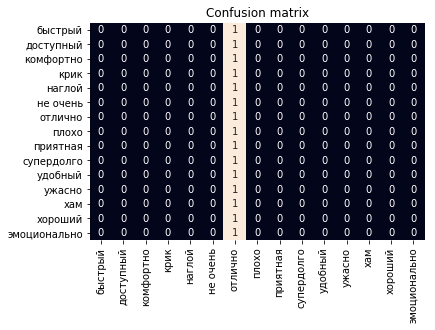

In [54]:
print("Precision: {0:6.2f}".format(precision_score(y, pred[:15], average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y, pred[:15], average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y, pred[:15], average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y, pred[:15])))
print(classification_report(y, pred[:15]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y, pred[:15]), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [55]:
from sklearn.semi_supervised import LabelPropagation

label_prop_model = LabelPropagation()

In [59]:
labels = [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
label_prop_model.fit(model.wv.wv.syn0[:15], labels)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000, n_jobs=1,
         n_neighbors=7, tol=0.001)

In [60]:
model.wv.similarity

<bound method WordEmbeddingsKeyedVectors.similarity of <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x1e00ea588>>

In [63]:
edges = []
for i in range(len(v)):
    sims = [(i, v.index(word[0])) for  word in  model.most_similar(v[i])]
    edges.append(sims)
edges

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[[(0, 1964),
  (0, 1687),
  (0, 496),
  (0, 4565),
  (0, 67),
  (0, 2904),
  (0, 305),
  (0, 801),
  (0, 3776),
  (0, 2228)],
 [(999, 27),
  (999, 1778),
  (999, 419),
  (999, 4675),
  (999, 1523),
  (999, 4310),
  (999, 4255),
  (999, 985),
  (999, 2404),
  (999, 122)],
 ...]

In [62]:
v = list(model.wv.vocab.keys())

In [67]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [68]:
import igraph as ig
g = ig.Graph(directed=True)
for word in model.wv.vocab.keys():
    g.add_vertex(word)
    
    
    
for word in model.wv.vocab.keys() :
    node = g.vs.select(name = word).indices[0]
    similar_words = model.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.
